In [3]:
import numpy as np
import csv
import matplotlib.pyplot as plt

In [4]:
def sigmoid(Z):
    S = 1 / (1 + np.exp(-Z))
    return S,Z

In [5]:
def derivade_sigmoid(z):
    gz,z = sigmoid(z) 
    return gz * (1-gz);

In [6]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network, (including input layer)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.normal(0, 1, (layer_dims[l], layer_dims[l-1]))
        parameters['b' + str(l)] = np.random.random((layer_dims[l], 1))
      
    return parameters

In [7]:
def initialize_velocity(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks (not input layer including)
    v = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l+1)])
        
    return v

# Forward Propagation in L - Layers

In [8]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    cache = (A, W, b)
    return Z, cache

In [9]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    cache = (linear_cache, activation_cache) #linear_cahce: A_prev,Wi,bi - activation_cache: Zi
    return A, cache

In [10]:
def L_model_forward(X,Y,parameters,pred=False):
    caches = []
    A = X                                     #(input size, number of examples)
    L = len(parameters) // 2              # number of layers in the neural network (not input layer including)
    
    # Implement [LINEAR -> SIGMOID]*(L-1). To L-1 Layers
    for l in range(1, L):
        A_prev = A 
        W=parameters['W' + str(l)]
        b=parameters['b' + str(l)]
        A, cache = linear_activation_forward(A_prev, W, b, "sigmoid")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Last layer
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    
    # Predicction
    if pred:
        Y_prediction = np.zeros((Y.shape[0], Y.shape[1]))
        for i in range(AL.shape[0]):
            # Convert probabilities a[0,i] to actual predictions p[0,i]
            for j in range(AL.shape[1]):
                Y_prediction[i, j] = 1 if AL[i, j] >= 0.5 else 0
        return Y_prediction
    return AL, caches

In [11]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (- 1 / m) * np.sum(Y * np.log(AL) + (1 - Y) * (np.log(1 - AL)))
    #cost = (-1 / m)  * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    #cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    return cost

# Backward Propagation in L - Layers

In [12]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ,A_prev.T)
    db = (1/m) * np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [13]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "sigmoid":
        dZ = dA * derivade_sigmoid(activation_cache) # activation_cache = Z ; dA = np.dot(W.T,dZ) excep the first dA
    
    dA_prev, dW, db = linear_backward(dZ, linear_cache)    
    return dA_prev, dW, db

In [14]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers (not input layer including)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # Initializing the backpropagation
    dAL =- (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, 
                                                                                                  current_cache, "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (SIGMOID -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "sigmoid")
        grads["dA" + str(l + 1)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db

    return grads


# Update Parameters

In [15]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network (not input layer including)

    for l in range(L):
        parameters["W" + str(l+1)] =parameters["W" + str(l+1)]-learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] =parameters["b" + str(l+1)]-learning_rate*grads["db" + str(l+1)]

    return parameters

# Update Parameters with Momentum

In [24]:
def update_parameters_with_momentum(parameters, grads, v, learning_rate, beta):
    L = len(parameters) // 2 # number of layers in the neural networks (not input layer including)
    
    # Momentum update for each parameter
    for l in range(L):
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads['db' + str(l + 1)]
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]
        
    return parameters, v

# L - layer model

In [27]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.5, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = []                         
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    #Velocity initialization.
    v = initialize_velocity(parameters)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> SIGMOID]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X,Y,parameters,pred=False)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        #parameters = update_parameters(parameters, grads, learning_rate)
        
        # Update parameters with Momentum.
        parameters, v = update_parameters_with_momentum(parameters, grads, v, learning_rate, beta = 0.9)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # Predicction
    Y_prediction =  L_model_forward(X,Y,parameters,pred=True)
    print("------------------")
    print("Prediccion:")
    print(Y_prediction)
    if np.array_equal(Y,Y_prediction):
        print("Success Prediction")
    else:
        print("Un - success Prediction")
        
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
            
    
    return parameters

(15, 15)
(15, 15)
Cost after iteration 0: 17.977078
Cost after iteration 100: 3.368677
Cost after iteration 200: 3.001658
Cost after iteration 300: 2.714420
Cost after iteration 400: 2.439309
Cost after iteration 500: 2.191273
Cost after iteration 600: 1.993661
Cost after iteration 700: 1.838761
Cost after iteration 800: 1.711590
Cost after iteration 900: 1.602278
Cost after iteration 1000: 1.504431
Cost after iteration 1100: 1.412756
Cost after iteration 1200: 1.325053
Cost after iteration 1300: 1.240059
Cost after iteration 1400: 1.151772
Cost after iteration 1500: 1.056504
Cost after iteration 1600: 0.969122
Cost after iteration 1700: 0.897047
Cost after iteration 1800: 0.836931
Cost after iteration 1900: 0.785886
Cost after iteration 2000: 0.741963
Cost after iteration 2100: 0.703737
Cost after iteration 2200: 0.670108
Cost after iteration 2300: 0.640202
Cost after iteration 2400: 0.613304
Cost after iteration 2500: 0.588827
Cost after iteration 2600: 0.566287
Cost after iteration 

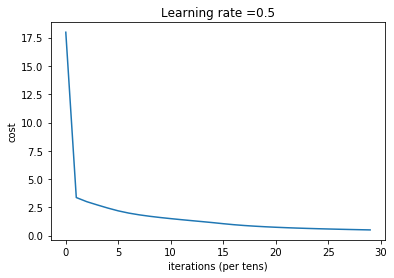

In [26]:
X = np.identity(15, dtype = float)
X= X.T
Y = X
#print(X)
#print(Y)
print(X.shape)
print(Y.shape)
layers_dims = [15, 4, 15] #  2-layer model
parameters = L_layer_model(X, Y, layers_dims, num_iterations = 3000, print_cost = True)